Importing needed

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

Hyper parameters

In [2]:
epochs=20#The numebr of times we run through the data
batch_size=64 #We learn 'batch by batch' so this is how many samples are in one batch 
learning_rate=0.1# step size in gradient descent used in moving toward minima of loss function

Preprocessing data, using tensorflow ONLY to import MNIST 

In [3]:
import tensorflow as tf #Tesnor flow is ONlY used to import MNIST in a nice form
from tensorflow.keras.datasets import mnist 

(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Flatten and normalize the training and testing data
x_train = x_train.reshape(-1, 784).astype('float32') / 255.0
x_test = x_test.reshape(-1, 784).astype('float32') / 255.0
# One-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
# Display the shapes of x_train, y_train, x_test, and y_test
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)
#Collumns should be inivdidual images
#We put y_true in form where collumns are predicitons and rows samples   
#Simillarly for y_true hot enocoded

x_train shape: (60000, 784)
y_train shape: (60000, 10)
x_test shape: (10000, 784)
y_test shape: (10000, 10)


Visualising the dataset

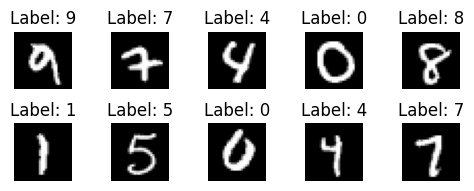

In [4]:
num_samples = 10  # Number of images to display
sample_indices = np.random.choice(x_train.shape[0], num_samples, replace=False)
sample_images = x_train[sample_indices]
sample_labels = y_train[sample_indices]

# Plot images in a grid
plt.figure(figsize=(5, 2))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)  # 2x5 grid
    plt.imshow(sample_images[i].reshape(28, 28), cmap='gray')
    plt.title(f'Label: {np.argmax(sample_labels[i])}')
    plt.axis('off')
plt.tight_layout()
plt.show()

Definning actiavation functions and derivatives, and loss:

In [5]:
#Different 'Activation functions' if we choose these function to be linear and our loss to be Mean squared error, we would get a Linear model the famous technically special case of the NN
def sigmoid(x):
     return (1/(1+np.exp(-x)))
def softmax(x):
     y = np.zeros_like(x, dtype=float)
     num_rows, num_columns = x.shape
     z=np.zeros(num_rows)
     for j in range(num_rows):
             z[j]=np.sum(np.exp(x[j,:]))
             y[j,:]=np.exp(x[j,:])/z[j]
     return y

#Categorical cross-entropy loss
def Loss(y_pred, y_true):
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)
        matrix=np.multiply(np.log(y_pred_clipped),y_true)
        samples, a =np.shape(y_true)
        loss=(1/samples)*np.sum(matrix)
        return loss


def sigmoidp(x): #derivative of sigmoid, used when calcualting gradients by chain rule
     return sigmoid(x)*(1 - sigmoid(x))


Making a Linear layer

In [6]:
#Bellow is making a class for a linear layer and the foreward and backpropagation
class Layer_Dense:
     def __init__(self, n_inputs, n_neruons):
          self.weights = 0.1*(np.random.randn(n_neruons, n_inputs))
          self.biases= 0.01 * np.random.randn(1, n_neruons)
          self.inputs=None
          self.output=None
     def forward(self, inputs,activation_function=sigmoid):
          m,n=np.shape(inputs) #n=numbebr of inputs(sample size)
          self.inputs=inputs
          self.output = activation_function((self.weights @ inputs.T).T +  np.tile(self.biases, (m, 1)))

     def backpropagation(self, dz, activation_derivative, learning_rate):
        # Calculate the derivative of the activation function
          dz = dz * activation_derivative(self.output)

            # Gradients for biases and weights
          db = np.sum(dz, axis=0) / dz.shape[0]
          dw = np.dot(dz.T, self.inputs) / dz.shape[0]

            # Calculate dz for the previous layer (backpropagation)
          dz_prev = np.dot(dz, self.weights)

            # Update weights and biases
          self.weights -= learning_rate * dw
          self.biases -= learning_rate * db

          return dz_prev

Neural Network

In [7]:
class NeuralNetwork:
    def __init__(self, input_size,  output_size):
                #Here we can add more layers
        self.layer1 = Layer_Dense(input_size, 256)
        self.layer2 = Layer_Dense(256, 512)
        self.layer3 = Layer_Dense(512, output_size)
   
    def forward(self, inputs):
        self.layer1.forward(inputs, activation_function=sigmoid)  
        self.layer2.forward(self.layer1.output, activation_function=sigmoid)
        #add sigmoid layers easily
        self.layer3.forward(self.layer2.output, activation_function=softmax)
        
        
    def backpropagation(self, x_batch, y_batch, learning_rate): #How our model learns
        
        self.forward(x_batch)

        dz = self.layer3.output - y_batch  #Here used gradient of loss function

        dz=self.layer3.backpropagation(dz, activation_derivative=lambda x: 1, learning_rate=learning_rate) #lambda x for last layer
        dz=self.layer2.backpropagation(dz, activation_derivative=sigmoidp, learning_rate=learning_rate)
        dz=self.layer1.backpropagation(dz, activation_derivative=sigmoidp, learning_rate=learning_rate)   #Sigmoid for additional layers

    def accuracy(self, y_true, y_pred):
        predictions = np.argmax(y_pred, axis=1)
        targets = np.argmax(y_true, axis=1)
        accuracy = np.mean(predictions  == targets) #finds accuracy
        return accuracy 

Initializing Neural Networks

In [8]:
nn = NeuralNetwork(input_size=x_train.shape[1],output_size=10)

Defining training and test loops

In [9]:
def train():
    for epoch in range(epochs):
        #Shuffles indices so each epochs is different:
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)

        num_samples = x_train.shape[0]
        num_batches = num_samples // batch_size
        
        for batch in range(num_batches):
            
            start_index = batch * batch_size
            end_index = start_index + batch_size

            batch_indices = indices[start_index:end_index]

            x_batch = x_train[batch_indices]
            y_batch = y_train[batch_indices]
            nn.backpropagation(x_batch, y_batch, learning_rate) #bac propagation
        
        # Print accuracy every 5 epochs
        if epoch % 5 == 0:
            nn.forward(x_test)
            y_pred = nn.layer3.output #Make sure here is the last layer
            print(f"Epoch {epoch}, Accuracy: {nn.accuracy(y_test, y_pred)}")
def test():
    nn.forward(x_test)
    y_pred = nn.layer3.output #Make sure here is the last layer
    print("Final test accuracy:", nn.accuracy(y_test, y_pred))

Running test and train

In [10]:
train()
test()

Epoch 0, Accuracy: 0.8882
Epoch 10, Accuracy: 0.9253
Epoch 20, Accuracy: 0.9321
